In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the combined parquet data

file_path = '/Users/maushariff/Downloads/Local_Disk_E/Byrav/Internet2_Data/Data/combined_router_dallas_atla_data.parquet'
df = pd.read_parquet(file_path)


In [3]:
# Convert 't_first' to datetime and set it as the index for resampling
df['t_first'] = pd.to_datetime(df['t_first'])

In [4]:
# Separate the Atlanta and Dallas data
atlanta_data = df[df['router'] == 'Atlanta'].resample('H', on='t_first')['in_packets'].sum().reset_index()
dallas_data = df[df['router'] == 'Dallas'].resample('H', on='t_first')['in_packets'].sum().reset_index()

# Rename columns for consistency
atlanta_data.columns = ['ds', 'y']
dallas_data.columns = ['ds', 'y']

/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_63145/1708584142.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  atlanta_data = df[df['router'] == 'Atlanta'].resample('H', on='t_first')['in_packets'].sum().reset_index()
/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_63145/1708584142.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dallas_data = df[df['router'] == 'Dallas'].resample('H', on='t_first')['in_packets'].sum().reset_index()


In [5]:
# Concatenate both datasets
combined_data = pd.concat([atlanta_data, dallas_data])

In [6]:
# Scale the data (you can scale separately for each router if needed)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['y']])


In [7]:
# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
sequence_length = 24  # Using 24 previous hours to predict the next hour

# Create sequences for LSTM
X, y = create_sequences(scaled_data, sequence_length)

In [8]:
# Reshape X for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [9]:
# Define the LSTM-GRU model
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Define model checkpoint
checkpoint = ModelCheckpoint("weights.best.keras", monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)


Epoch 1/200
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0122 - mae: 0.0714 - mse: 0.0122
Epoch 1: val_mse improved from inf to 0.00979, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0121 - mae: 0.0711 - mse: 0.0121 - val_loss: 0.0098 - val_mae: 0.0511 - val_mse: 0.0098
Epoch 2/200
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - mae: 0.0450 - mse: 0.0052
Epoch 2: val_mse improved from 0.00979 to 0.00447, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0052 - mae: 0.0449 - mse: 0.0052 - val_loss: 0.0045 - val_mae: 0.0435 - val_mse: 0.0045
Epoch 3/200
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - mae: 0.0408 - mse: 0.0040
Epoch 3: val_mse improved from 0.00447 to 0.00364, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0040 - mae: 0.0408 - mse: 0.0040 - val_loss: 0.0036 - val_mae: 0.0339 - val_mse: 0.0036
Epoch 4/200
120/122 ━━━━━━━━━━━━━━━

In [12]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual data
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [13]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}')

Test MAE: 144402530.96393442, Test RMSE: 199256400.4602458


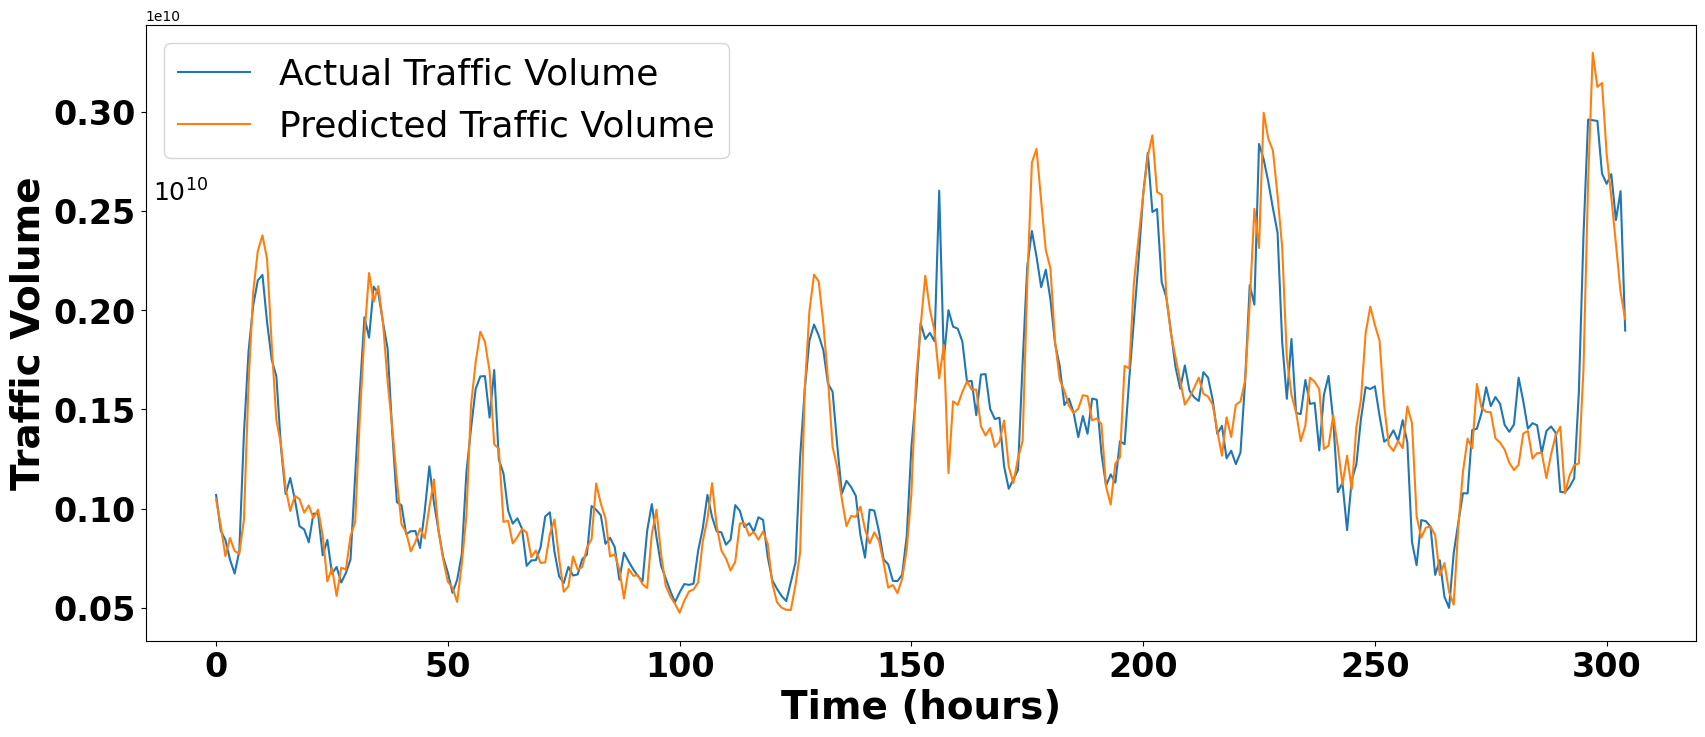

In [48]:
# # Plot the results
# plt.figure(figsize=(20, 8))
# plt.plot(y_test_rescaled, label='Actual Traffic Volume')
# plt.plot(predictions_rescaled, label='Predicted Traffic Volume')
# plt.title('Traffic Volume Prediction using LSTM-GRU')
# plt.xlabel('Time (hours)')
# plt.ylabel('Traffic Volume')
# plt.legend()
# plt.show()


import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(y_test_rescaled, label='Actual Traffic Volume')
plt.plot(predictions_rescaled, label='Predicted Traffic Volume')

# Remove the title
# plt.title('Traffic Volume Prediction using LSTM-GRU')

# Increase font size for labels and legend
plt.xlabel('Time (hours)', fontsize=28, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=28, fontweight='bold')
plt.legend(fontsize=26)

# Suppress scientific notation at the top and add custom label
plt.ticklabel_format(style='sci', axis='y', scilimits=(10, 10), useOffset=False)
plt.annotate(r'$10^{10}$', xy=(0.005, 0.75), xycoords='axes fraction', fontsize=18,
                 verticalalignment='top', fontweight='bold')

# Increase font size for tick labels on x and y axes
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')

# Show the plot
plt.show()



Mean Squared Error (MSE): 3.970311312437384e+16
Mean Absolute Error (MAE): 144402530.96393442
R-squared: 0.870710876872273
Adjusted R-squared: 0.870284180096274
Mean Squared Log Error (MSLE): 0.02107021620397426
Mean Absolute Percentage Error (MAPE): 0.10992612987502418


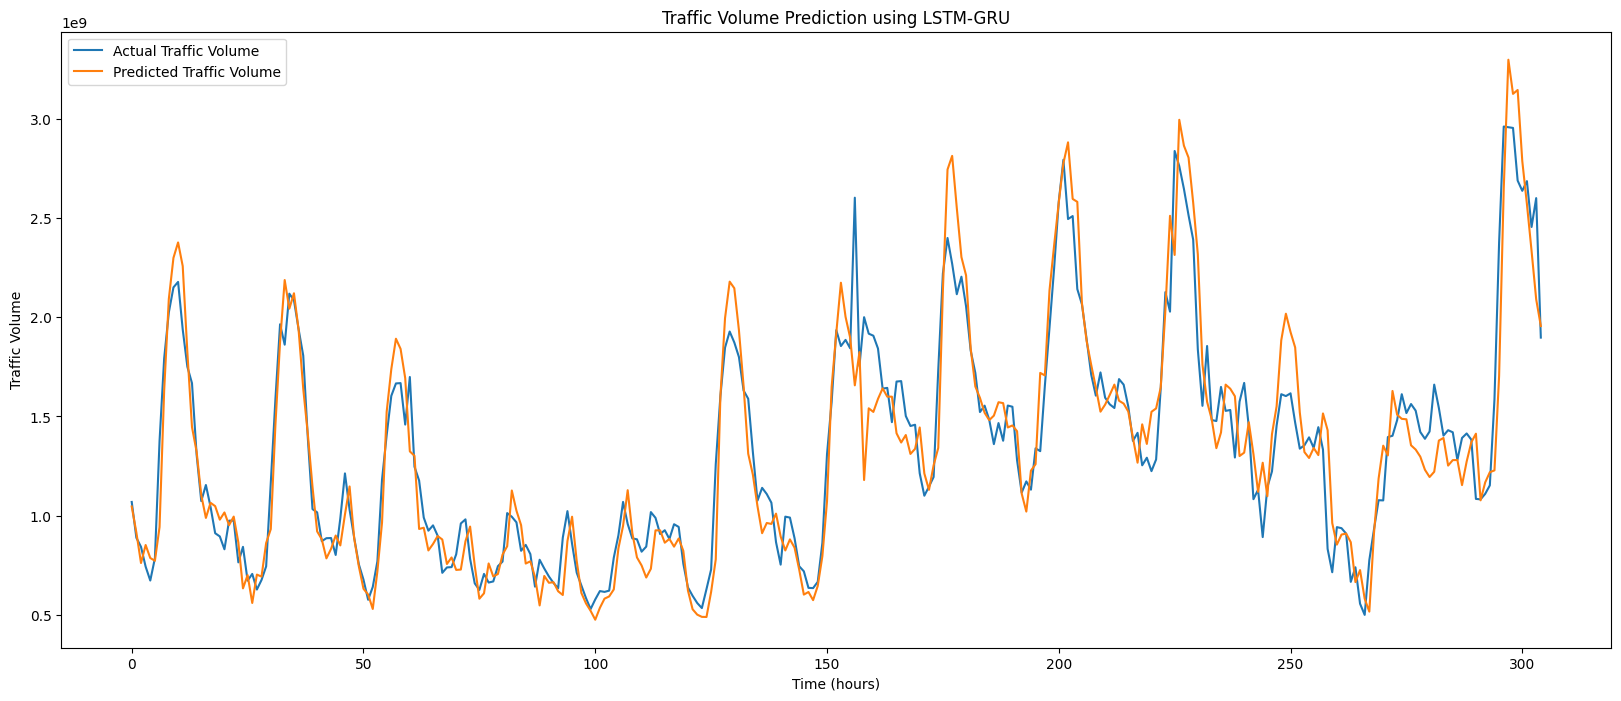

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error

# Evaluate the model with additional metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)
adjusted_r2 = 1 - (1 - r2) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[2] - 1))
msle = mean_squared_log_error(y_test_rescaled, predictions_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")
print(f"Mean Squared Log Error (MSLE): {msle}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(y_test_rescaled, label='Actual Traffic Volume')
plt.plot(predictions_rescaled, label='Predicted Traffic Volume')
plt.title('Traffic Volume Prediction using LSTM-GRU')
plt.xlabel('Time (hours)')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [16]:
from prophet import Prophet# Initialize the Prophet models for both routers

prophet_atlanta = Prophet()
prophet_dallas = Prophet()

# Fit the models
prophet_atlanta.fit(atlanta_data)
prophet_dallas.fit(dallas_data)

# Create future dataframe for prediction (next 48 hours)
future_atlanta = prophet_atlanta.make_future_dataframe(periods=48, freq='H')
future_dallas = prophet_dallas.make_future_dataframe(periods=48, freq='H')

# Predict using the models
forecast_atlanta = prophet_atlanta.predict(future_atlanta)
forecast_dallas = prophet_dallas.predict(future_dallas)

/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

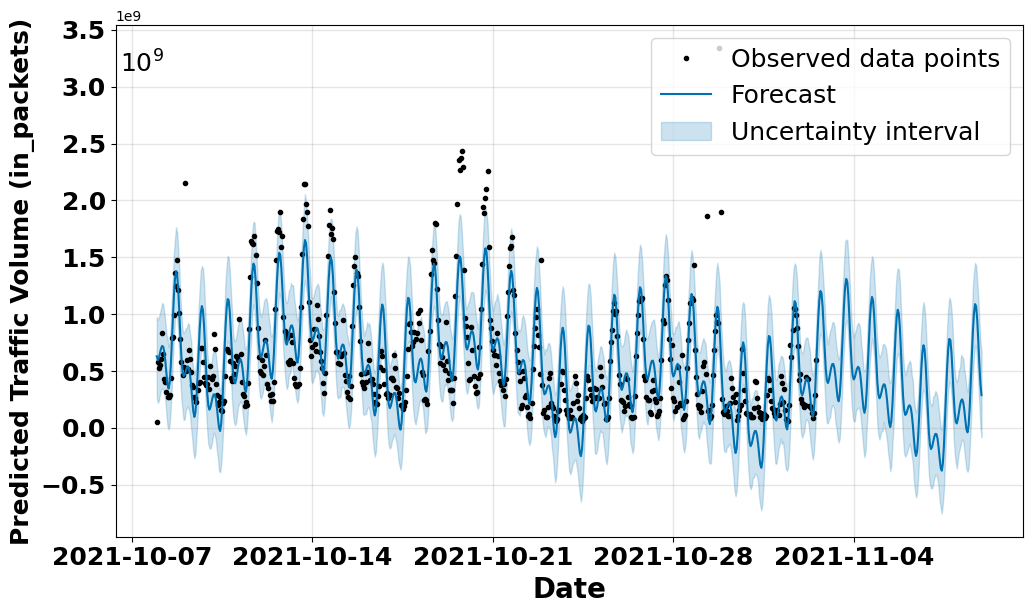

<Figure size 1000x600 with 0 Axes>

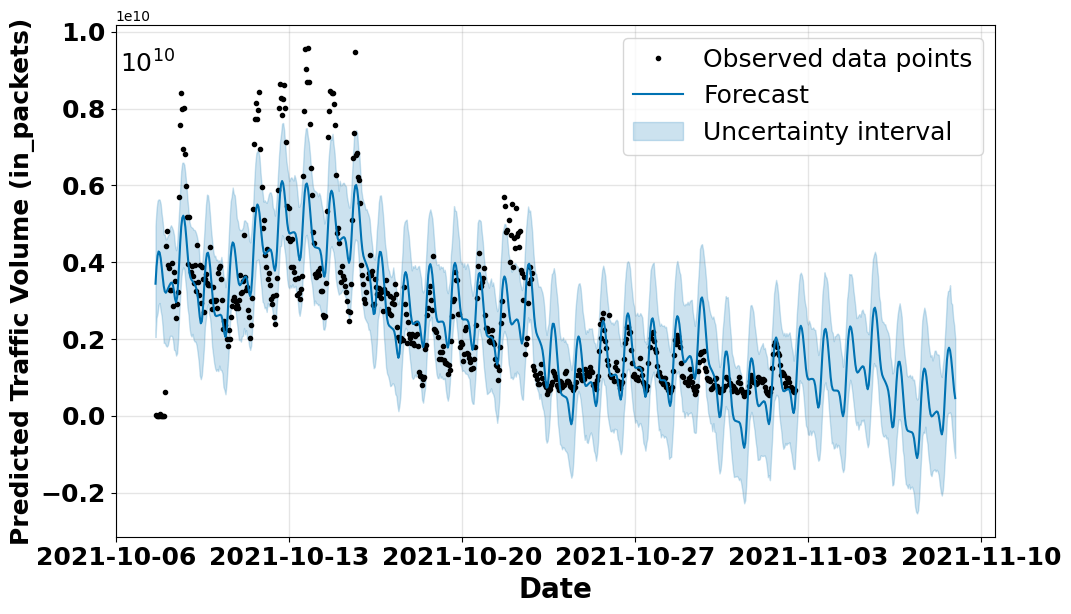

/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/Vs

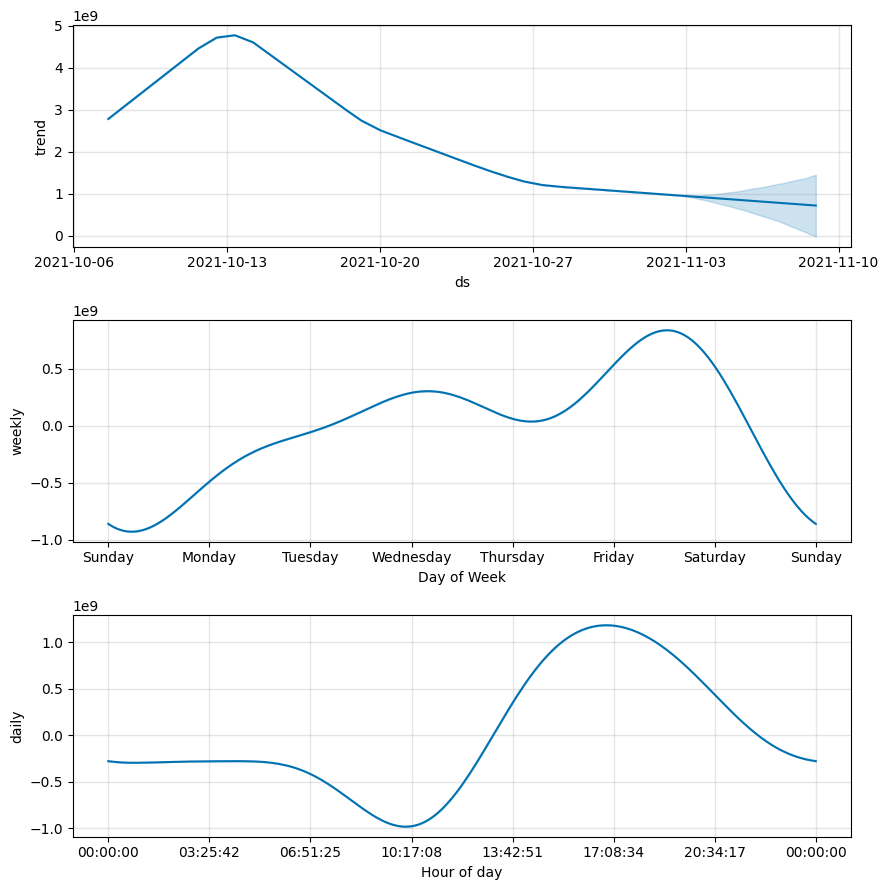

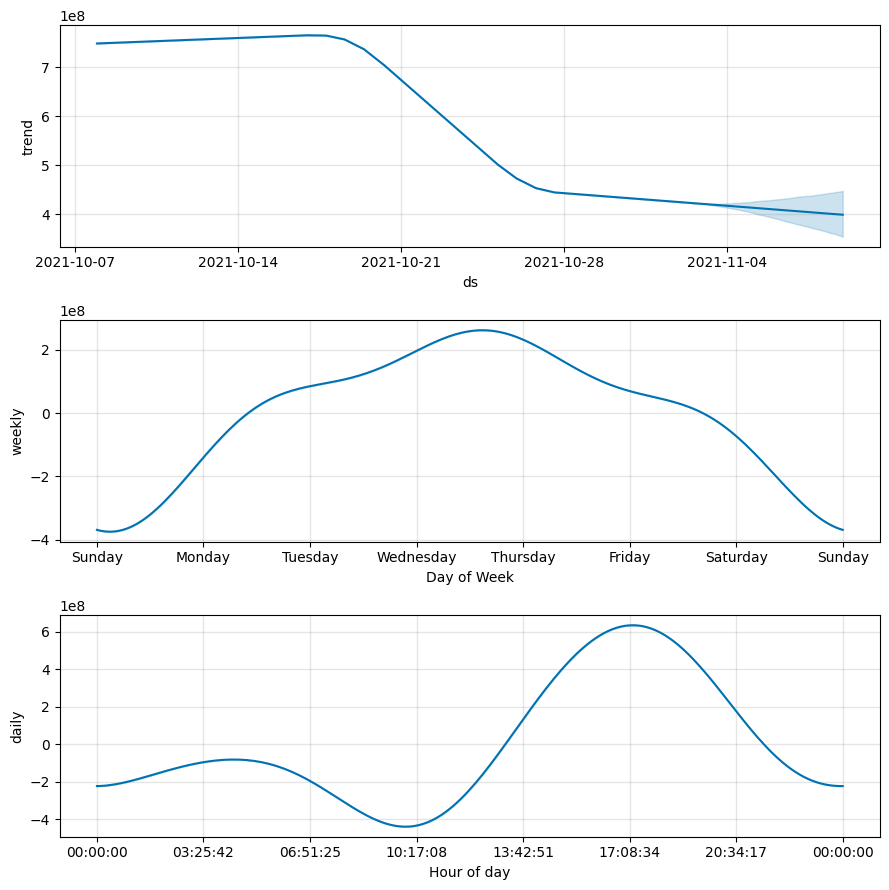

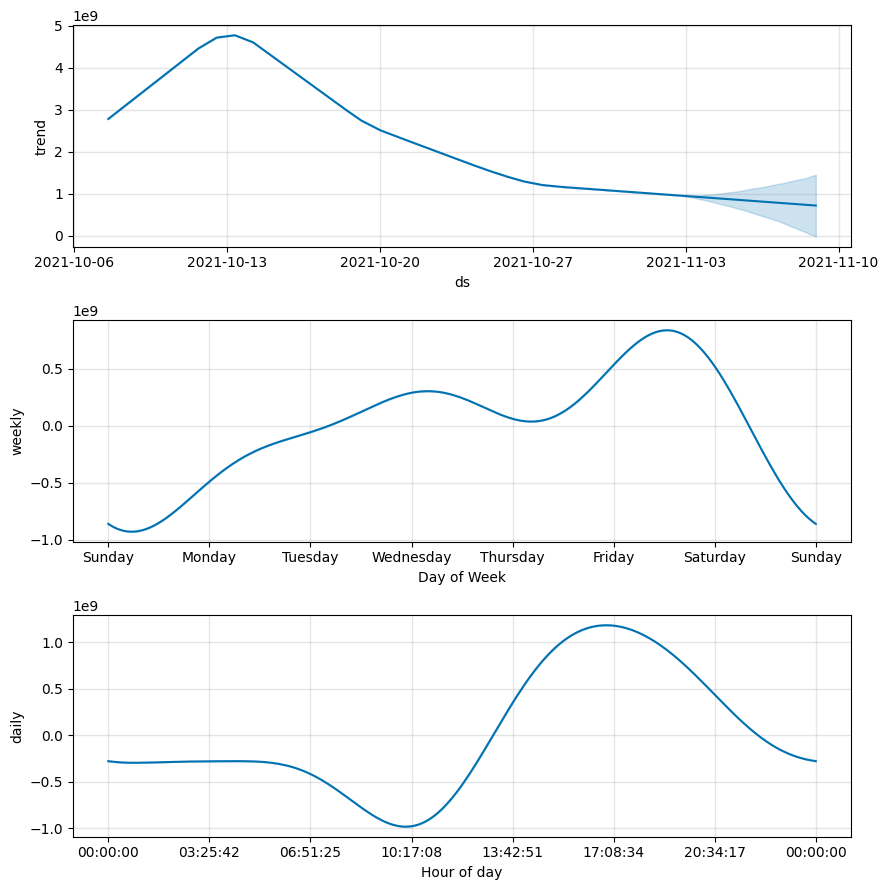

In [58]:
# Plot the forecasts for Atlanta
plt.figure(figsize=(10, 6))
prophet_atlanta.plot(forecast_atlanta)
# plt.title('Prophet Forecast for Atlanta Router Traffic Volume')
plt.xlabel('Date', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Traffic Volume (in_packets)', fontsize=18, fontweight='bold')
# Increase font size for labels and legend
plt.legend(fontsize=18)
# Increase font size for tick labels on x and y axes
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# # Suppress scientific notation at the top and add custom label
# plt.ticklabel_format(style='sci', axis='y', scilimits=(10, 10), useOffset=False)
plt.annotate(r'$10^{9}$', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=18,
                 verticalalignment='top', fontweight='bold')


plt.show()


# Plot the forecasts for Dallas
plt.figure(figsize=(10, 6))
prophet_dallas.plot(forecast_dallas)
# plt.title('Prophet Forecast for Dallas Router Traffic Volume')
plt.xlabel('Date', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Traffic Volume (in_packets)', fontsize=18, fontweight='bold')
# Increase font size for labels and legend
plt.legend(fontsize=18)
# Increase font size for tick labels on x and y axes
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# Suppress scientific notation at the top and add custom label
plt.ticklabel_format(style='sci', axis='y', scilimits=(10, 10), useOffset=False)
plt.annotate(r'$10^{10}$', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=18,
                 verticalalignment='top', fontweight='bold')


plt.show()

# Optional: Plot components to see trend and seasonality
prophet_atlanta.plot_components(forecast_atlanta)
# plt.title('Trend and Seasonality Components for Atlanta Router')

prophet_dallas.plot_components(forecast_dallas)
# plt.title('Trend and Seasonality Components for Dallas Router')

# # Optional: Export the predictions for further analysis
# forecast_atlanta[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_atlanta.csv', index=False)
# forecast_dallas[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_dallas.csv', index=False)

In [18]:
# Train-test split: Use last 20% of data for evaluation (adjust if necessary)
def train_test_split_prophet(df, split_fraction=0.8):
    split_point = int(len(df) * split_fraction)
    train = df[:split_point]
    test = df[split_point:]
    return train, test

atlanta_train, atlanta_test = train_test_split_prophet(atlanta_data)
dallas_train, dallas_test = train_test_split_prophet(dallas_data)

# Initialize the Prophet models for both routers
prophet_atlanta = Prophet()
prophet_dallas = Prophet()

# Fit the models
prophet_atlanta.fit(atlanta_train)
prophet_dallas.fit(dallas_train)

# Create future dataframe for prediction (forecasting on the test set)
future_atlanta = prophet_atlanta.make_future_dataframe(periods=len(atlanta_test), freq='H')
future_dallas = prophet_dallas.make_future_dataframe(periods=len(dallas_test), freq='H')


23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
23:35:06 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [19]:
# Predict using the models
forecast_atlanta = prophet_atlanta.predict(future_atlanta)
forecast_dallas = prophet_dallas.predict(future_dallas)

# Extract the predicted yhat values
predicted_atlanta = forecast_atlanta[['ds', 'yhat']].tail(len(atlanta_test))['yhat'].values
predicted_dallas = forecast_dallas[['ds', 'yhat']].tail(len(dallas_test))['yhat'].values

# Get the actual values from the test set
actual_atlanta = atlanta_test['y'].values
actual_dallas = dallas_test['y'].values


Atlanta Router Evaluation Metrics:
MSE: 5.137283470118758e+16
MAE: 180122812.22773978
R-squared: 0.5851607423232412
Adjusted R-squared: 0.582431536680631
MSLE: Not applicable due to negative values.
MAPE: 0.7598582201829839

Dallas Router Evaluation Metrics:
MSE: 8.374600802653151e+17
MAE: 772377811.40633
R-squared: -2.1524842972933667
Adjusted R-squared: -2.1729549745485186
MSLE: Not applicable due to negative values.
MAPE: 0.5804653783528718


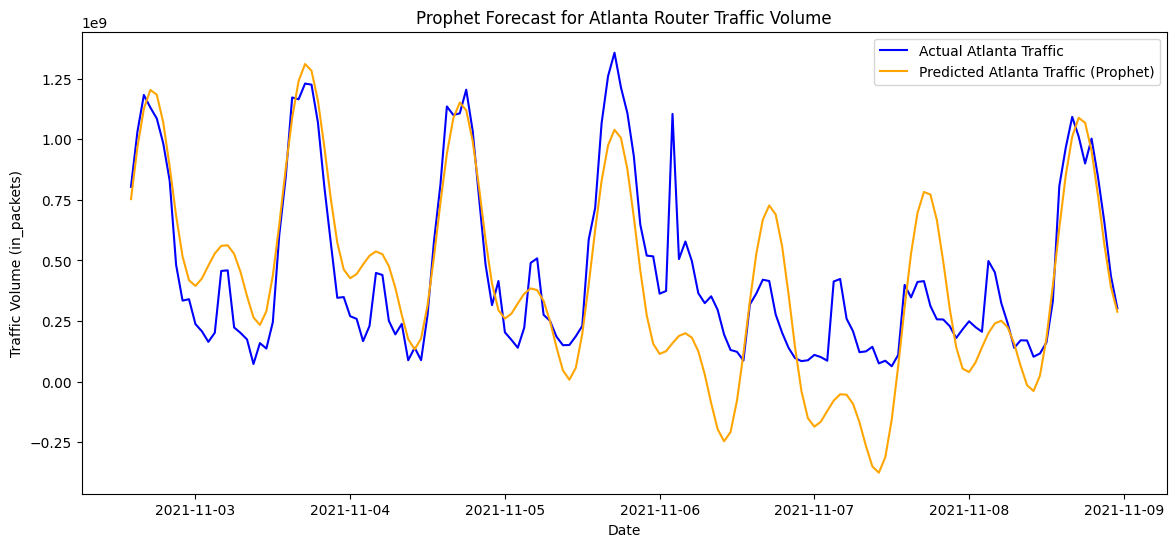

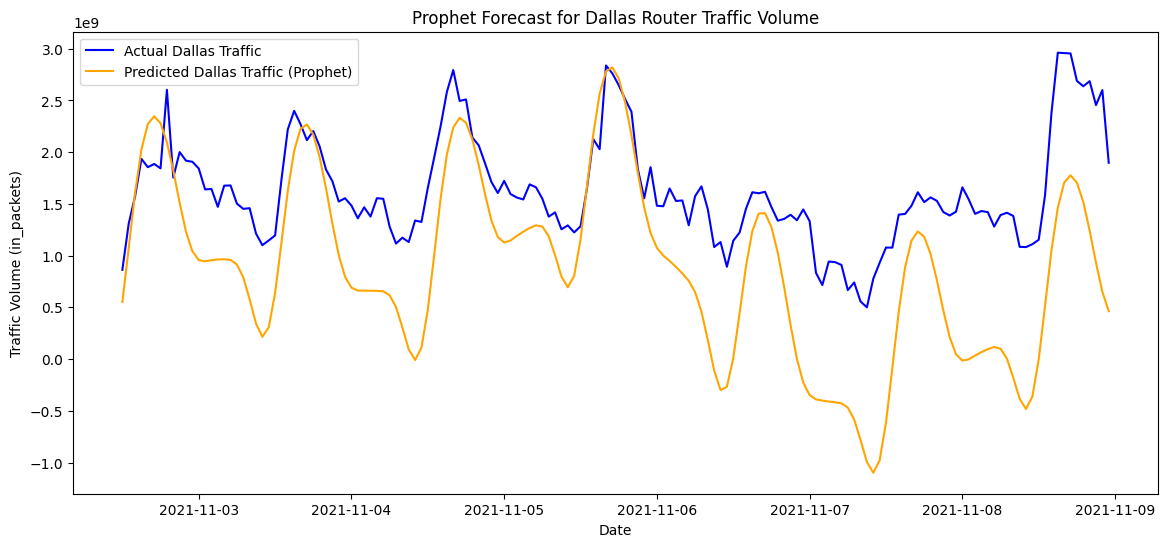

In [20]:
# Evaluation metrics for Prophet model
def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)

    # Adjusted R-squared calculation
    n = len(actual)  # Number of samples
    p = 1  # Number of predictors (only 1 here: the predicted traffic)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    # Conditionally compute MSLE if there are no negative values
    if np.all(actual >= 0) and np.all(predicted >= 0):
        from sklearn.metrics import mean_squared_log_error
        msle = mean_squared_log_error(actual, predicted)
    else:
        msle = None  # Skip MSLE if there are negative values

    return {
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "Adjusted R-squared": adjusted_r2,
        "MSLE": msle,  # May be None if skipped
        "MAPE": mape
    }

# Evaluate Prophet for both Atlanta and Dallas
atlanta_metrics = evaluate_model(actual_atlanta, predicted_atlanta)
dallas_metrics = evaluate_model(actual_dallas, predicted_dallas)

# Print results for both routers
print("Atlanta Router Evaluation Metrics:")
for metric, value in atlanta_metrics.items():
    if value is not None:
        print(f"{metric}: {value}")
    else:
        print(f"{metric}: Not applicable due to negative values.")

print("\nDallas Router Evaluation Metrics:")
for metric, value in dallas_metrics.items():
    if value is not None:
        print(f"{metric}: {value}")
    else:
        print(f"{metric}: Not applicable due to negative values.")

# Plot the forecasts for Atlanta
plt.figure(figsize=(14, 6))
plt.plot(atlanta_test['ds'], actual_atlanta, label='Actual Atlanta Traffic', color='blue')
plt.plot(atlanta_test['ds'], predicted_atlanta, label='Predicted Atlanta Traffic (Prophet)', color='orange')
plt.title('Prophet Forecast for Atlanta Router Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume (in_packets)')
plt.legend()
plt.show()

# Plot the forecasts for Dallas
plt.figure(figsize=(14, 6))
plt.plot(dallas_test['ds'], actual_dallas, label='Actual Dallas Traffic', color='blue')
plt.plot(dallas_test['ds'], predicted_dallas, label='Predicted Dallas Traffic (Prophet)', color='orange')
plt.title('Prophet Forecast for Dallas Router Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume (in_packets)')
plt.legend()
plt.show()